In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import logging
import warnings


from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import Lasso, LogisticRegression

from rich import print

%load_ext rich

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("PreferenceLearningTask")

SEED = 42
random = np.random.RandomState(SEED)


## Load data

In [2]:
data = pd.read_csv("./data/train.csv")

In [3]:
data

,Choice,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,A_network_feature_1,...,B_following_count,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3
0,0,228,302,3,0.583979,0.100503,0.100503,0.100503,0.362150,2,...,29808,1689,15.430498,3.984029,8.204331,0.332423,6.988815,66,75.530303,1916.893939
1,0,21591,1179,228,90.456506,25.798292,5.709329,1.111159,5.176620,369,...,848,1610,40.495021,8.943607,3.227677,0.564343,1.070321,163,132.030675,2931.515337
2,0,7310,1215,101,25.503644,9.556347,5.361519,0.591206,3.589718,95,...,482,206,0.734696,0.354379,0.603202,0.100503,0.603202,3,10.333333,277.333333
3,0,20,7,2,7.690824,0.277306,1.331508,0.100503,2.830627,6,...,17637,278,572.874856,390.293681,27.552040,7.167557,32.101906,1762,23.469296,1395.845634
4,1,45589,862,2641,148.854279,36.998884,27.881768,3.333492,23.861282,551,...,1711,181,21.601866,3.581661,6.764657,1.119727,4.563246,85,48.500000,1993.627907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5495,0,41765,185,1356,1529.643058,282.858500,76.809514,5.392171,104.438625,3307,...,1370,15143,6881.482996,5013.642295,22.683131,2.385538,18.420981,23958,21.324988,1413.825398
5496,1,112,243,5,1.445174,0.100503,0.100503,0.100503,0.603177,5,...,479,8,0.306073,0.306073,0.100503,0.100503,1.621981,1,49.000000,4969.000000
5497,0,15385,673,747,55.993546,22.321945,6.946233,0.341936,6.503977,202,...,1711,181,21.601866,3.581661,6.764657,1.119727,4.563246,85,48.500000,1993.627907
5498,0,265258,209,551,631.915946,457.648550,5.460985,0.100503,7.498126,2603,...,37601,22232,176.533716,42.330221,6.849227,1.345073,4.359865,696,234.338068,7168.464489


### Exploratory Data Analysis

In [4]:
def plot_metric(data, metric_name):
    plt.figure(figsize=(10, 10))

    plot = sns.scatterplot(
        data=data, x=f"A_{metric_name}", y=f"B_{metric_name}", hue="Choice"
    )

    plot.set_title(f"Metric: {metric_name}")
    plt.show()

    return None


In [5]:
metric_names = [metric.replace("A_", "") for metric in data.columns if "A_" in metric]
metric_names



[
    'follower_count',
    'following_count',
    'listed_count',
    'mentions_received',
    'retweets_received',
    'mentions_sent',
    'retweets_sent',
    'posts',
    'network_feature_1',
    'network_feature_2',
    'network_feature_3'
]

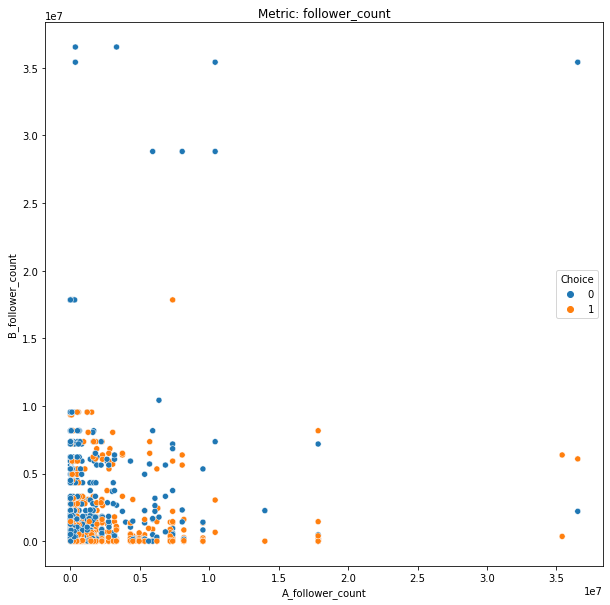

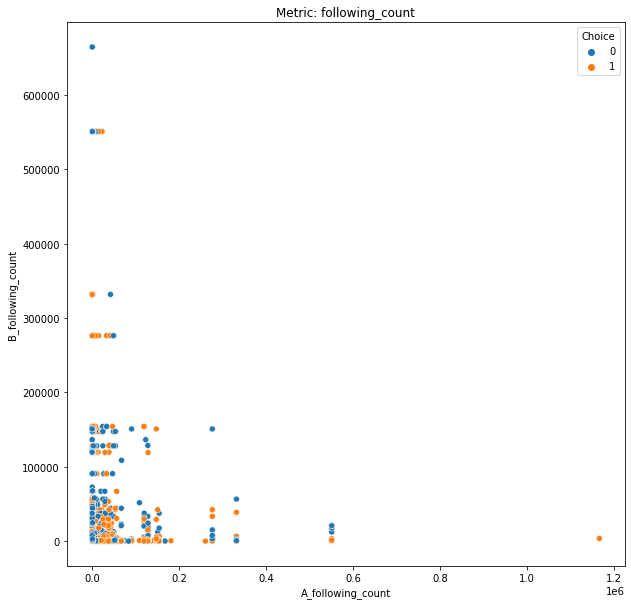

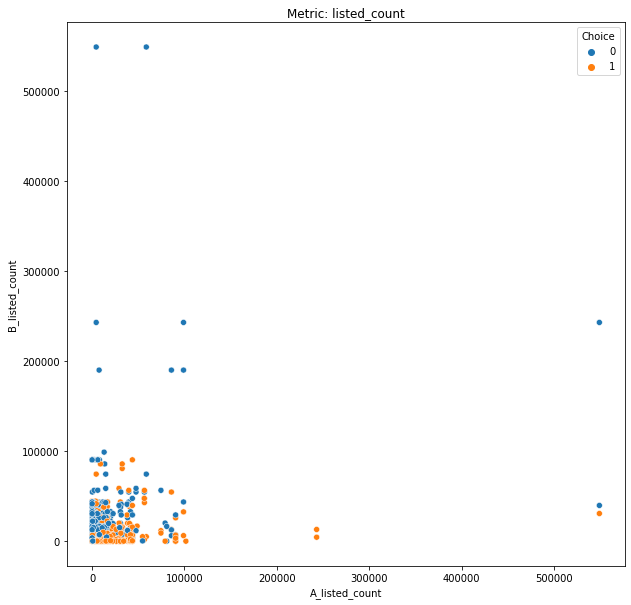

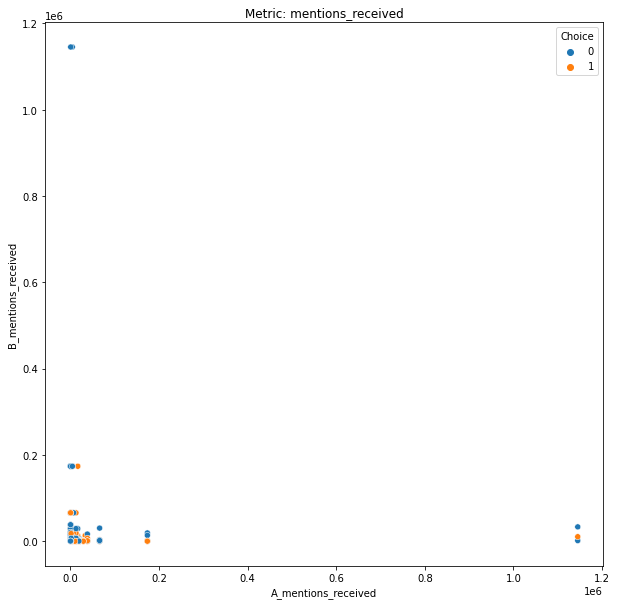

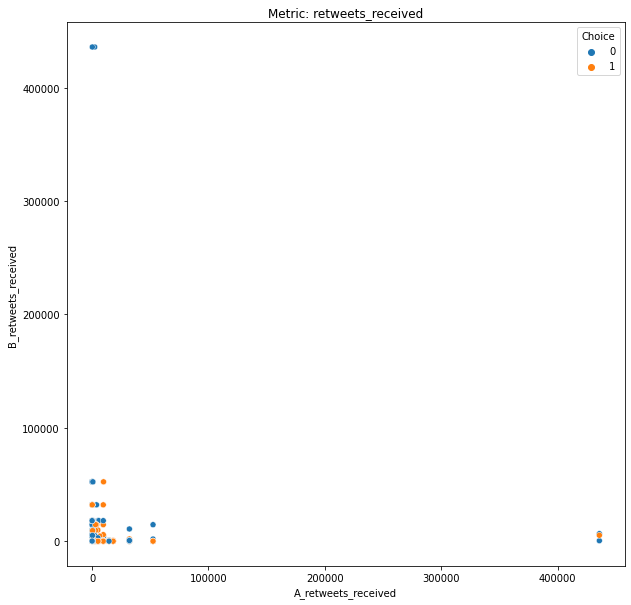

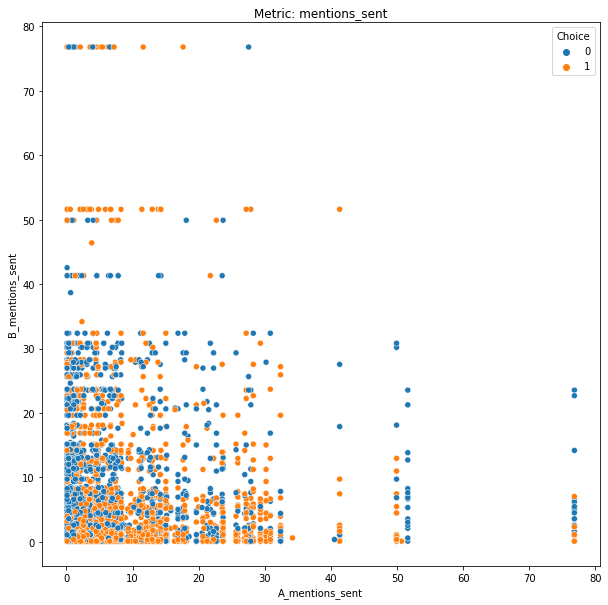

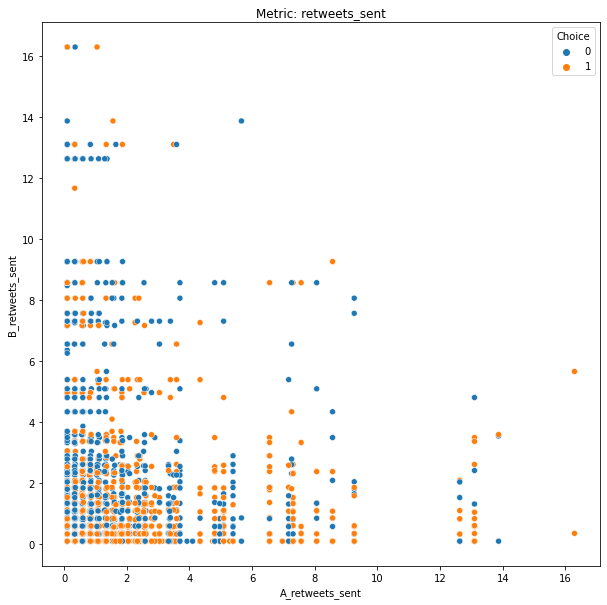

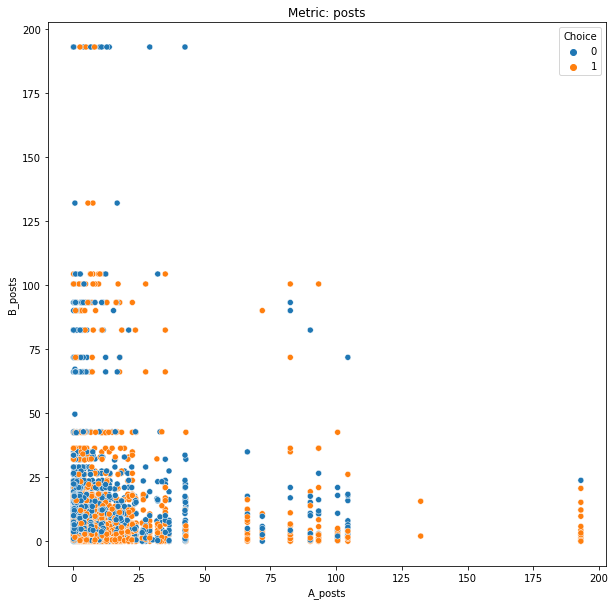

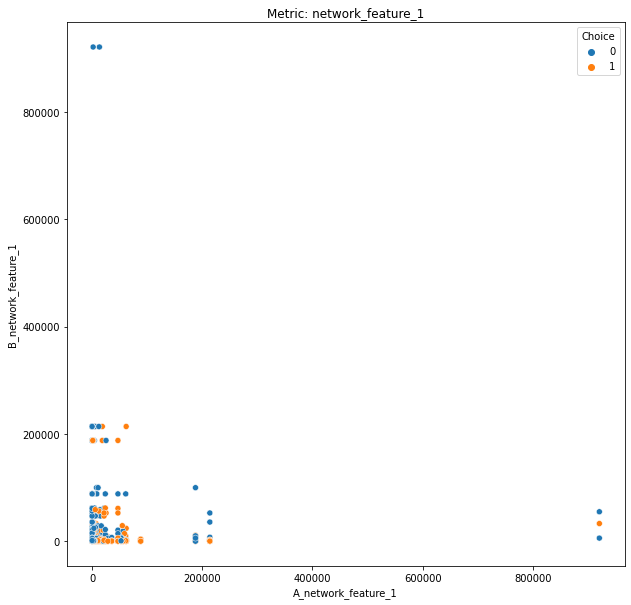

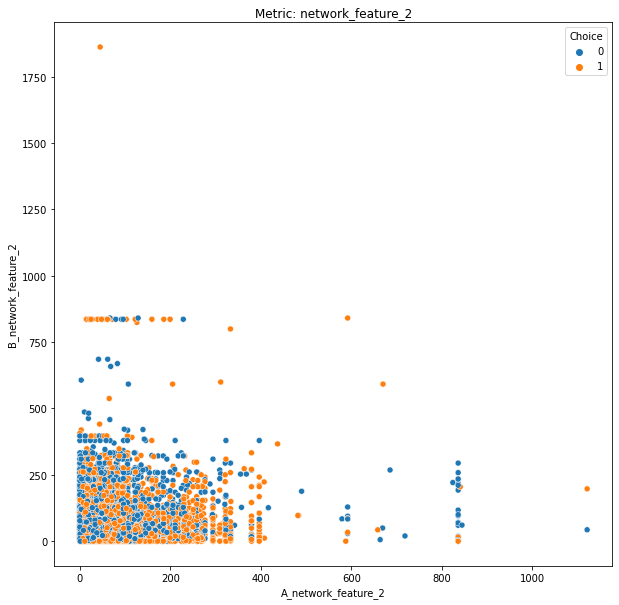

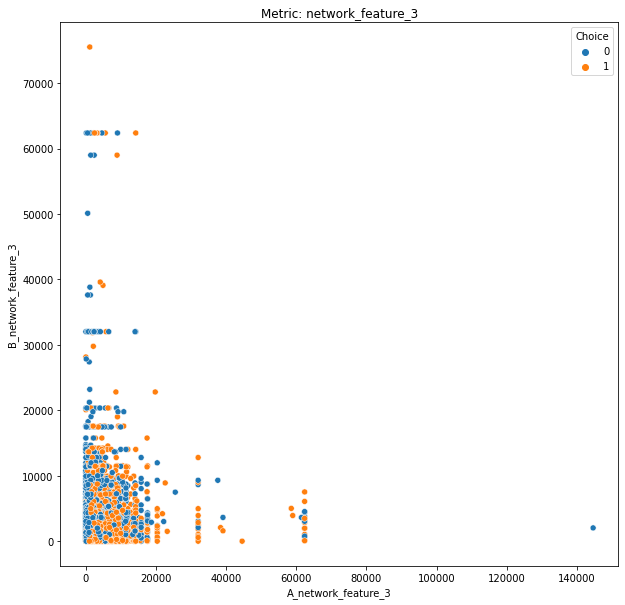

[None, None, None, None, None, None, None, None, None, None, None]

In [6]:
[plot_metric(data, metric_name) for metric_name in metric_names]

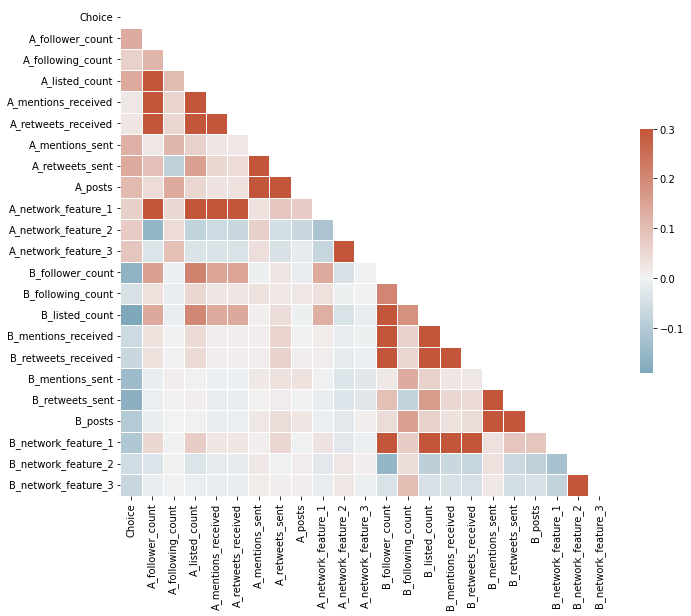

In [7]:
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(
    corr,
    mask=mask,
    cmap=sns.diverging_palette(230, 20, as_cmap=True),
    vmax=0.3,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)

plt.show()

In [8]:
X, y = data.drop(columns=["Choice"]), data["Choice"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")

X_train shape: (4400, 22)

X_val shape: (1100, 22)

## Pipeline

In [9]:
# Build custom functions to perform feature engineering

def divide_columns(X):
    result = np.divide(
        X[:, 0].astype(float),
        X[:, 1].astype(float),
        out=np.zeros_like(X[:, 0], dtype=float),
        where=X[:, 1] != 0,
    )
    return result[:, np.newaxis]  # Reshape the result to be 2D


def divide_columns_feature_names(F, feature_names):
    return ["ratio"]


def subtract_columns(X):
    result = np.subtract(
        X[:, 0].astype(float),
        X[:, 1].astype(float),
    )
    return result[:, np.newaxis]  # Reshape the result to be 2D


def subtract_columns_feature_names(F, feature_names):
    return ["difference"]


def engagement_columns_subtract(X):
    # Calculate engagement for A
    engagement_A = np.add(X[:, 0].astype(float), X[:, 1].astype(float))
    engagement_ratio_A = np.divide(
        X[:, 2].astype(float),
        engagement_A,
        out=np.zeros_like(X[:, 0], dtype=float),
        where=engagement_A != 0,
    )
    normalized_result_A = np.divide(
        engagement_ratio_A,
        X[:, 3].astype(float),
        out=np.zeros_like(engagement_ratio_A, dtype=float),
        where=X[:, 3].astype(float) != 0,
    )

    # Calculate engagement for B
    engagement_B = np.add(X[:, 4].astype(float), X[:, 5].astype(float))
    engagement_ratio_B = np.divide(
        X[:, 6].astype(float),
        engagement_B,
        out=np.zeros_like(X[:, 4], dtype=float),
        where=engagement_B != 0,
    )
    normalized_result_B = np.divide(
        engagement_ratio_B,
        X[:, 7].astype(float),
        out=np.zeros_like(engagement_ratio_B, dtype=float),
        where=X[:, 7].astype(float) != 0,
    )

    # Calculate the difference in engagement between A and B
    engagement_difference = np.subtract(normalized_result_A, normalized_result_B)

    return engagement_difference[:, np.newaxis]  # Reshape the result to be 2D

def engagement_columns_divide(X):
    # Calculate engagement for A
    engagement_A = np.add(X[:, 0].astype(float), X[:, 1].astype(float))
    engagement_ratio_A = np.divide(
        X[:, 2].astype(float),
        engagement_A,
        out=np.zeros_like(X[:, 0], dtype=float),
        where=engagement_A != 0,
    )
    normalized_result_A = np.divide(
        engagement_ratio_A,
        X[:, 3].astype(float),
        out=np.zeros_like(engagement_ratio_A, dtype=float),
        where=X[:, 3].astype(float) != 0,
    )

    # Calculate engagement for B
    engagement_B = np.add(X[:, 4].astype(float), X[:, 5].astype(float))
    engagement_ratio_B = np.divide(
        X[:, 6].astype(float),
        engagement_B,
        out=np.zeros_like(X[:, 4], dtype=float),
        where=engagement_B != 0,
    )
    normalized_result_B = np.divide(
        engagement_ratio_B,
        X[:, 7].astype(float),
        out=np.zeros_like(engagement_ratio_B, dtype=float),
        where=X[:, 7].astype(float) != 0,
    )

    # Calculate the difference in engagement between A and B
    engagement_division = np.divide(
        normalized_result_A,
        normalized_result_B,
        out=np.zeros_like(normalized_result_A, dtype=float),
        where=normalized_result_B != 0,
    )
    return engagement_division[:, np.newaxis]  # Reshape the result to be 2D



def engagement_columns_feature_names(F, feature_names):
    return ["engagement"]


divide_transformer = make_pipeline(
    StandardScaler(),
    FunctionTransformer(
        divide_columns, validate=False, feature_names_out=divide_columns_feature_names
    ),
)

subtract_transformer = make_pipeline(
    StandardScaler(),
    FunctionTransformer(
        subtract_columns,
        validate=False,
        feature_names_out=subtract_columns_feature_names,
    ),
)

engagement_transformer_subtract = make_pipeline(
    StandardScaler(),
    FunctionTransformer(
        engagement_columns_subtract,
        validate=False,
        feature_names_out=subtract_columns_feature_names,
    ),
)
engagement_transformer_divide = make_pipeline(
    StandardScaler(),
    FunctionTransformer(
        engagement_columns_divide,
        validate=False,
        feature_names_out=divide_columns_feature_names,
    ),
)

# 'follower_count',
# 'following_count',
# 'listed_count',
# 'mentions_received',
# 'retweets_received',
# 'mentions_sent',
# 'retweets_sent',
# 'posts',

preprocessing = ColumnTransformer(
    [
        (
            "follower_count",
            subtract_transformer,
            ["A_follower_count", "B_follower_count"],
        ),
        (
            "following_count",
            subtract_transformer,
            ["A_following_count", "B_following_count"],
        ),
        (
            "engagement",
            engagement_transformer_subtract,
            [
                "A_mentions_received", "A_retweets_received", "A_posts", "A_follower_count",
                "B_mentions_received", "B_retweets_received", "B_posts", "B_follower_count"
            ],
        ),
        (
            "listed_count",
            subtract_transformer,
            ["A_listed_count", "B_listed_count"],
        ),
        (
            "mentions_received",
            subtract_transformer,
            ["A_mentions_received", "B_mentions_received"],
        ),
        (
            "retweets_received",
            subtract_transformer,
            ["A_follower_count", "B_follower_count"],
        ),
        (
            "mentions_sent",
            subtract_transformer,
            ["A_mentions_sent", "B_mentions_sent"],
        ),
        (
            "retweets_sent",
            subtract_transformer,
            ["A_retweets_sent", "B_retweets_sent"],
        ),
    ],
    # remainder="passthrough",
)

In [10]:
X_train_processed = pd.DataFrame(
    preprocessing.fit_transform(X_train), columns=preprocessing.get_feature_names_out()
)

X_train_processed

,follower_count__difference,following_count__difference,engagement__difference,listed_count__difference,mentions_received__difference,retweets_received__difference,mentions_sent__difference,retweets_sent__difference
0,1.080446,-0.044195,5.921062,0.413445,0.006305,1.080446,-0.616943,-0.515437
1,-0.755097,0.026351,-8.935583,-0.571571,-0.012250,-0.755097,0.742371,0.525194
2,0.196223,0.033471,-38.356592,0.117563,-0.026375,0.196223,-0.547371,1.832273
3,0.020480,-0.005039,-140.705095,-0.071757,-0.052191,0.020480,-7.226891,-1.588388
4,-0.110207,-0.125044,-4.361954,-0.232651,-0.007835,-0.110207,-0.710617,-0.889085
...,...,...,...,...,...,...,...,...
4395,0.003835,0.033072,25.105087,0.040456,0.002851,0.003835,2.255533,0.118874
4396,-0.380771,1.384174,-286.385122,-0.034550,-0.112417,-0.380771,-1.295038,-0.401882
4397,-0.234218,0.025941,11.605719,-0.220694,-0.042550,-0.234218,0.620921,0.276665
4398,0.562149,0.005902,-15.392550,2.128056,0.086272,0.562149,0.226523,1.964869


In [11]:
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, random_state=SEED),
    "Logistic": LogisticRegression(random_state=SEED),
    "AdaBoost": AdaBoostClassifier(random_state=SEED),
    "Lasso":Lasso(random_state=SEED)
}

pipelines = {}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for name, model in models.items():
        if name == "Lasso":  # Lasso requires a different approach
            pipeline = make_pipeline(preprocessing, model)
            pipeline.fit(X_train, y_train)
            # For Lasso, we need to transform the continuous output to binary for classification purposes
            y_pred = np.where(pipeline.predict(X_val) > 0.5, 1, 0)
            score = accuracy_score(y_val, y_pred)
            pipelines[name] = pipeline
            print(f"{name} score: {score}")
        else:
            pipeline = make_pipeline(preprocessing, model)
            pipeline.fit(X_train, y_train)
            pipelines[name] = pipeline
            print(f"{name} score: {pipeline.score(X_val, y_val)}")


RandomForest score: 0.7554545454545455

GradientBoosting score: 0.7527272727272727

Logistic score: 0.7190909090909091

AdaBoost score: 0.759090909090909

Lasso score: 0.5145454545454545

#### We can observe that the RandomForest, GradientBoosting and AdaBoost models have the best performance. Now we will test these with divide transformer

In [12]:
preprocessing_divide = ColumnTransformer(
    [
        (
            "follower_count",
            divide_transformer,
            ["A_follower_count", "B_follower_count"],
        ),
        (
            "following_count",
            divide_transformer,
            ["A_following_count", "B_following_count"],
        ),
        (
            "engagement",
            engagement_transformer_divide,
            [
                "A_mentions_received", "A_retweets_received", "A_posts", "A_follower_count",
                "B_mentions_received", "B_retweets_received", "B_posts", "B_follower_count"
            ],
        ),
        (
            "listed_count",
            divide_transformer,
            ["A_listed_count", "B_listed_count"],
        ),
        (
            "mentions_received",
            divide_transformer,
            ["A_mentions_received", "B_mentions_received"],
        ),
        (
            "retweets_received",
            divide_transformer,
            ["A_follower_count", "B_follower_count"],
        ),
        (
            "mentions_sent",
            divide_transformer,
            ["A_mentions_sent", "B_mentions_sent"],
        ),
        (
            "retweets_sent",
            divide_transformer,
            ["A_retweets_sent", "B_retweets_sent"],
        ),
    ],
    # remainder="passthrough",
)

models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, random_state=SEED),
    "AdaBoost": AdaBoostClassifier(random_state=SEED)
}

pipelines_division = {}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for name, model in models.items():
        pipeline = make_pipeline(preprocessing_divide, model)
        pipeline.fit(X_train, y_train)
        pipelines_division[name] = pipeline
        print(f"{name} score: {pipeline.score(X_val, y_val)}")


RandomForest score: 0.7554545454545455

GradientBoosting score: 0.7627272727272727

AdaBoost score: 0.7436363636363637

We can see the GradientBoosting model has the highest accuracy score. We will use this model to make predictions on the test set.

In [13]:
feature_importances = pipelines_division["GradientBoosting"].named_steps["gradientboostingclassifier"].feature_importances_
feature_names = preprocessing_divide.get_feature_names_out()
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)
print(feature_df)

Feature  Importance
4  mentions_received__ratio    0.543635
3       listed_count__ratio    0.132708
5  retweets_received__ratio    0.098359
0     follower_count__ratio    0.079810
1    following_count__ratio    0.046116
6      mentions_sent__ratio    0.042881
2         engagement__ratio    0.035502
7      retweets_sent__ratio    0.020989

When using division between A and B for listed received, mentions received and retweet received, the performance of the model is better than subtraction. 

Gradient Boosting Accuracy: 0.7627272727272727

Gradient Boosting Confusion Matrix:

<Axes: >

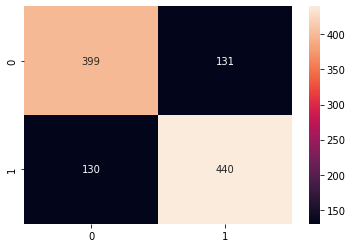

In [14]:
# Gradient Boosting Model from pipelines_division
y_pred_gb = pipelines_division["GradientBoosting"].predict(X_val)
cm_gb = confusion_matrix(y_val, y_pred_gb)
accuracy_gb = accuracy_score(y_val, y_pred_gb)
print(f"Gradient Boosting Accuracy: {accuracy_gb}")
print("Gradient Boosting Confusion Matrix:")
sns.heatmap(cm_gb, annot=True, fmt='d')

In [15]:
#adding a predcited_choice on the whole dataset i.e X

X["predicted_choice"] = pipelines_division["GradientBoosting"].predict(X)
#add Y to the dataset
X["Choice"] = y

X.to_csv("./data/train_processed_final.csv", index=False)


# Financial value of the model 
A retailer wants influencers to tweet its promotion for a product. 
- If a non-influencer tweets, there is  no benefit to the retailer. 
- If an influencer tweets once, there is a 0.02% chance that his/her followers  will buy one unit of a product. 
- Profit margin of $10 per unit, and that one  customer can buy only one unit. 
- If an influencer tweets twice, the overall buying probability will be 0.03%. 
- Without analytics, the retailer offers $5 to each person (A and B) to tweet once. 
- With analytics,  the retailer offers $10 to those identified as influencers by the model to send two tweets each. 
- If the  model classifies an individual as a non-influencer, s/he is not selected/paid by the retailer to tweet. 

### Questions
- What is the boost in expected net profit from using your analytic model (versus not using analytics)? 
- What is the boost in net profit from using a perfect analytic model (versus not using analytics)?

In [16]:
#Profit calculation

data_profit = X.copy()

data_profit.head()

,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,A_network_feature_1,A_network_feature_2,...,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3,predicted_choice,Choice
0,228,302,3,0.583979,0.100503,0.100503,0.100503,0.362150,2,166.500000,...,15.430498,3.984029,8.204331,0.332423,6.988815,66,75.530303,1916.893939,0,0
1,21591,1179,228,90.456506,25.798292,5.709329,1.111159,5.176620,369,18.442971,...,40.495021,8.943607,3.227677,0.564343,1.070321,163,132.030675,2931.515337,1,0
2,7310,1215,101,25.503644,9.556347,5.361519,0.591206,3.589718,95,68.927835,...,0.734696,0.354379,0.603202,0.100503,0.603202,3,10.333333,277.333333,1,0
3,20,7,2,7.690824,0.277306,1.331508,0.100503,2.830627,6,2.000000,...,572.874856,390.293681,27.552040,7.167557,32.101906,1762,23.469296,1395.845634,0,0
4,45589,862,2641,148.854279,36.998884,27.881768,3.333492,23.861282,551,127.404293,...,21.601866,3.581661,6.764657,1.119727,4.563246,85,48.500000,1993.627907,1,1


In [17]:
#Profit without using analytics
# (A_follower_count + B_follower_count)*0.0002*10*0.5 - 5*total_rows*2

total_rows = data_profit.shape[0]
Revenue_no_analytics = (data_profit["A_follower_count"] + data_profit["B_follower_count"]).sum()*0.0002*10*0.5 #0.5 is the probability of A being an influencer
Cost_no_analytics = 5*total_rows*2
profit_no_analytics = Revenue_no_analytics - Cost_no_analytics

print(f"Profit without using analytics: $ {profit_no_analytics}")
print(f"Revenue without using analytics: $ {Revenue_no_analytics}")
print(f"Cost without using analytics: $ {Cost_no_analytics}")

Profit without using analytics: $ 7289539.46

Revenue without using analytics: $ 7344539.46

Cost without using analytics: $ 55000

In [18]:
#Profit using Perfect model
# Revenue_perfect_model if Choice == 1 then (A_follower_count)*0.0003*10  else (B_follower_count)*0.0003*10

Revenue_perfect_model = data_profit.apply(lambda x: x["A_follower_count"]*0.0003*10 if x["Choice"] == 1 else x["B_follower_count"]*0.0003*10, axis=1).sum()

Cost_perfect_model = 10*total_rows

profit_perfect_model = Revenue_perfect_model - Cost_perfect_model

print(f"Profit using perfect model: $ {profit_perfect_model}")
print(f"Revenue using perfect model: $ {Revenue_perfect_model}")
print(f"Cost using perfect model: $ {Cost_perfect_model}")

Profit using perfect model: $ 16074705.779

Revenue using perfect model: $ 16129705.779

Cost using perfect model: $ 55000

In [19]:
#Profit using analytics (Our model)
# Revenue_our_model_A if predicted_choice == 1 && choice ==1 then (A_follower_count)*0.0003*10  else 0
# Revenue_our_model_B if predicted_choice == 0 && choice ==0 then (B_follower_count)*0.0003*10  else 0

Revenue_our_model_A = data_profit.apply(lambda x: x["A_follower_count"]*0.0003*10 if x["predicted_choice"] == 1 and x["Choice"] == 1 else 0, axis=1).sum()
Revenue_our_model_B = data_profit.apply(lambda x: x["B_follower_count"]*0.0003*10 if x["predicted_choice"] == 0 and x["Choice"] == 0 else 0, axis=1).sum()

Cost_our_model = 10*total_rows

profit_our_model = Revenue_our_model_A + Revenue_our_model_B - Cost_our_model

print(f"Profit using our model: $ {profit_our_model}")
print(f"Revenue using our model: $ {Revenue_our_model_A + Revenue_our_model_B}")
print(f"Cost using our model: $ {Cost_our_model}")

Profit using our model: $ 14196882.074

Revenue using our model: $ 14251882.074

Cost using our model: $ 55000

In [20]:
#Printing Profits in millions for all three cases
profit_no_analytics_rounded = round(profit_no_analytics/1000000, 2)
profit_our_model_rounded = round(profit_our_model/1000000, 2)
profit_perfect_model_rounded = round(profit_perfect_model/1000000, 2)

print(f"Profit without using analytics: $ {profit_no_analytics_rounded} Million")
print(f"Profit using our model: $ {profit_our_model_rounded} Million")
print(f"Profit using perfect model: $ {profit_perfect_model_rounded} Million")


Profit without using analytics: $ 7.29 Million

Profit using our model: $ 14.2 Million

Profit using perfect model: $ 16.07 Million

In [21]:
# Inference based on profit comparison
profit_without_analytics = 7.29  # in millions
profit_with_our_model = 14.2  # in millions
profit_with_perfect_model = 16.07  # in millions

# Calculating the percentage of the potential profit captured by our model
potential_profit_increase = profit_with_perfect_model - profit_without_analytics
actual_profit_increase = profit_with_our_model - profit_without_analytics
percentage_of_potential_profit_captured = (actual_profit_increase / potential_profit_increase) * 100

print(f"Using our analytics-based approach, we have improved our profits by {(actual_profit_increase / profit_without_analytics) * 100:.2f}% compared to not using analytics.")
print(f"Our model captures {percentage_of_potential_profit_captured:.2f}% of the potential profit increase achievable with the perfect model.")


Using our analytics-based approach, we have improved our profits by 94.79% compared to not using analytics.

Our model captures 78.70% of the potential profit increase achievable with the perfect model.